In [2]:
!pip install pyvis
!pip install geopy

In [3]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import random
from itertools import chain
import geopy.distance
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Cours 3A/Projet 3A/Challenge Alstom - IA PAU'

/content/drive/MyDrive/Cours 3A/Projet 3A/Challenge Alstom - IA PAU


In [6]:
!ls

ChallengeAlstomIAPau.ipynb  data  lib  network_graph.html


## Network plan

In [34]:
df_network_plan = pd.read_csv('data/plan_metro.csv')
df_network_plan.info()
df_network_plan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      1010 non-null   object
 1   de Station    1010 non-null   object
 2   vers Ligne    1010 non-null   object
 3   vers Station  1010 non-null   object
dtypes: object(4)
memory usage: 31.7+ KB


,de Ligne,de Station,vers Ligne,vers Station
0,1,Charles de Gaulle - Étoile,2,Charles de Gaulle - Étoile
1,1,Charles de Gaulle - Étoile,6,Charles de Gaulle - Étoile
2,1,Franklin D. Roosevelt,9,Franklin D. Roosevelt
3,1,Champs-Élysées - Clemenceau,13,Champs-Élysées - Clemenceau
4,1,Concorde,8,Concorde


In [35]:
#removing inter-station where target corresponds to a tramway station
df_network_plan = df_network_plan[~df_network_plan['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

In [9]:
print(set(df_network_plan['vers Ligne'].unique()) == set(df_network_plan['de Ligne'].unique()))

True


In [10]:
print(set(df_network_plan['vers Station'].unique()) == set(df_network_plan['de Station'].unique()))

True


In [37]:
df_position = pd.read_csv('data/position_gps_stations.csv')
df_position.info()
df_position.head()

#Removing Malsesherbes RER Station
df_position = df_position.drop([151])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  386 non-null    object
 1   GPS      386 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


In [38]:
network_stations = {station : {} for station in df_network_plan['de Station'].unique()}
reverse_network_stations = {}

# unique (station, line) couples that we're using as nodes in our graph
df_nodes = df_network_plan.groupby(['de Station','de Ligne']).size().reset_index().rename(columns={0:'count'})

count=0
for node in df_nodes.values:

  network_stations[node[0]].update({node[1] : count})
  reverse_network_stations.update({count : {'title' : node[0], 'group' :node[1]}})
  count+=1

In [39]:
unspecified_loc_nodes = []
for station, station_lines in network_stations.items():
  df_coords = df_position[df_position['Station'] == station]
  if not df_coords.empty:
    complete_gps = []
    if len(station_lines.values()) - len(df_coords['GPS'].values) > 0:
      for _ in range(len(station_lines.values()) - len(df_coords['GPS'].values)):
        complete_gps.append(random.choice(df_coords['GPS'].values))

    for coord, node_station in zip([*df_coords['GPS'].values, *complete_gps], station_lines.values()):
      lat, lon = coord.split(', ')
      lat, lon = float(lat), float(lon)
      reverse_network_stations[node_station].update({'lon':lon, 'lat':lat})
  else:
    unspecified_loc_nodes = [*unspecified_loc_nodes, *station_lines.values()]

In [40]:
edges = []
for edge in df_network_plan.values:
  edges.append((network_stations[edge[1]][edge[0]], network_stations[edge[3]][edge[2]]))

In [12]:
def get_node_neighbors(G, node, distance=1):
  if distance == 1:
    neighbors = list(G.neighbors(node))
    return neighbors
  else:
    neighbors = list(G.neighbors(node))
    total_neighbors = [neighbors.copy()]
    for neighbor in neighbors:
      total_neighbors.append(get_node_neighbors(G, neighbor, distance-1))
    total_neighbors = list(chain(*total_neighbors))
    return list(set(total_neighbors))
    # return list(chain(*total_neighbors))

In [41]:
network_graph = nx.Graph()
network_graph.add_edges_from(edges)
nx.set_node_attributes(network_graph, reverse_network_stations)

In [42]:
min_dist = 3
max_dist = 3
unspecified_loc_nodes_pos = {}
for node_station in unspecified_loc_nodes:
  mean_lat, mean_lon = [], []
  for dist in range(min_dist,max_dist+1):
    for neighbor in get_node_neighbors(network_graph, node_station, distance=dist):

      lon = reverse_network_stations[neighbor].get('lon')
      lat = reverse_network_stations[neighbor].get('lat')
      if lon is not None and lat is not None:
        mean_lat.append(lat)
        mean_lon.append(lon)

    if len(mean_lat) > 0 and len(mean_lon) > 0:
      unspecified_loc_nodes_pos.update({node_station : {'lon' : sum(mean_lon)/len(mean_lon), 'lat': sum(mean_lat)/len(mean_lat)}})
      break
    else:
      print(node_station)
      continue
nx.set_node_attributes(network_graph, unspecified_loc_nodes_pos)

## Adding edge weight based on distance between stations

In [43]:
for edge in network_graph.edges:
  start_node = network_graph.nodes[edge[0]]
  end_node = network_graph.nodes[edge[1]]
  distance = geopy.distance.geodesic((start_node['lat'], start_node['lon']), (end_node['lat'], end_node['lon'])).km
  network_graph.edges[edge]['inv_dist_km'] = 1/distance if distance != 0 else 1.0

## Network visualization

### With `pyvis`



In [49]:
net_viz = Network()
net_viz.from_nx(network_graph)
net_viz.save_graph('network_graph_test.html')

### Using `networkx` API

In [50]:
test_stations = network_stations['Pont de Sèvres'].values()
for station in test_stations:
  print([network_graph.nodes[neighbor] for neighbor in network_graph.neighbors(station)])

[{'title': 'Pointe du Lac', 'group': '9', 'lon': 2.464280070543357, 'lat': 48.76881073420608}, {'title': 'Billancourt', 'group': '9', 'lon': 2.2374367869806067, 'lat': 48.83173796437048}]


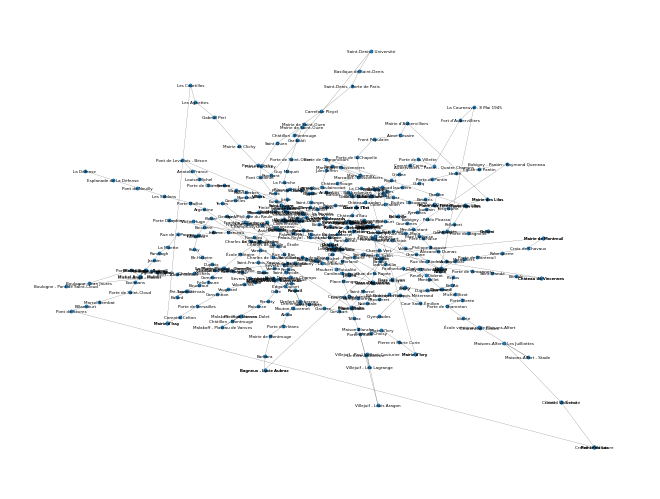

In [46]:
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in network_graph.nodes.items()}

nx.draw(network_graph, node_size=3, width=0.1, pos=pos, labels=nx.get_node_attributes(network_graph, 'title'), font_size=3)
#

## Flow for each path

In [16]:
df_flow = pd.read_csv('data/passagers.csv')
df_flow.info()
df_flow.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


,de,vers,nombre
0,La Défense,Esplanade de La Défense,7
1,La Défense,Pont de Neuilly,5
2,La Défense,Les Sablons,6
3,La Défense,Porte Maillot,6
4,La Défense,Argentine,5


In [70]:
network_stations_hub = {k :v for k,v in network_stations.items() if len(v) > 1}
start_station = np.random.choice(list(network_stations_hub.keys()))
start_station

'Concorde'

In [78]:
test_path = df_flow[df_flow['de'] == start_station].sample(1)
print(test_path)
# path_idx = np.random.randint(0, len(df_flow))
# test_path = df_flow.iloc[path_idx]
# print(test_path)
start_station = test_path['de'].values[0]
end_station = test_path['vers'].values[0]
flow = test_path['nombre'].values[0]

            de        vers  nombre
3125  Concorde  Parmentier       4


In [82]:
def get_best_path(network_stations, start_station, end_station):
  lb_path_weight = 0
  for start_node in network_stations[start_station].values():
    for end_node in network_stations[end_station].values():
      current_path = nx.dijkstra_path(network_graph, start_node, end_node, weight='inv_dist_km')
      current_path_weight = sum([network_graph.edges[edge]['inv_dist_km'] for edge in zip(current_path[:-1], current_path[1:])])
      if current_path_weight > lb_path_weight:
        lb_path_weight = current_path_weight
        best_path = current_path
  return best_path

best_path = get_best_path(network_stations, start_station, end_station)

In [76]:
print(" ->\n".join([f'{reverse_network_stations[node]["title"]} ({reverse_network_stations[node]["group"]})' for node in best_path]))

Concorde (12) ->
Madeleine (12) ->
Saint-Lazare (12) ->
Saint-Lazare (14) ->
Madeleine (14) ->
Pyramides (14) ->
Châtelet (14) ->
Châtelet (7) ->
Châtelet (1) ->
Hôtel de Ville (1) ->
Saint-Paul (1) ->
Bastille (1) ->
Gare de Lyon (1) ->
Reuilly - Diderot (1) ->
Nation (1) ->
Nation (9) ->
Buzenval (9) ->
Maraîchers (9)


In [83]:
def get_nodes_traffic(network_graph, df_flow):
  nodes_traffic = {node_idx : {'traffic' : 0} for node_idx in network_graph.nodes}
  for path_idx in range(len(df_flow)):
    path = df_flow.iloc[path_idx]
    start_station = path['de']
    end_station = path['vers']
    flow = path['nombre']
    best_path = get_best_path(network_stations, start_station, end_station)
    for node in best_path:
      nodes_traffic[node]['traffic'] += flow
  return nodes_traffic

nodes_traffic = get_nodes_traffic(network_graph, df_flow)
nodes_traffic

{60: {'traffic': 50257},
 61: {'traffic': 51633},
 62: {'traffic': 82743},
 116: {'traffic': 52651},
 117: {'traffic': 26861},
 55: {'traffic': 60219},
 56: {'traffic': 55371},
 84: {'traffic': 41069},
 86: {'traffic': 31078},
 85: {'traffic': 20384},
 251: {'traffic': 39104},
 252: {'traffic': 9807},
 73: {'traffic': 79876},
 76: {'traffic': 50641},
 77: {'traffic': 80775},
 74: {'traffic': 47480},
 75: {'traffic': 58297},
 146: {'traffic': 68960},
 147: {'traffic': 39763},
 21: {'traffic': 75865},
 22: {'traffic': 18261},
 23: {'traffic': 9066},
 128: {'traffic': 61982},
 129: {'traffic': 10928},
 324: {'traffic': 65363},
 325: {'traffic': 47256},
 233: {'traffic': 26608},
 234: {'traffic': 10797},
 236: {'traffic': 16125},
 238: {'traffic': 19210},
 394: {'traffic': 58612},
 395: {'traffic': 43079},
 270: {'traffic': 47828},
 269: {'traffic': 22511},
 264: {'traffic': 45990},
 263: {'traffic': 12989},
 18: {'traffic': 46895},
 19: {'traffic': 32504},
 367: {'traffic': 38237},
 368: 

In [89]:
total_trafic = sum([node['traffic'] for node in nodes_traffic.values()])
print(total_trafic)
normalized_nodes_traffic = {node_idx : {'traffic' : 1000*node['traffic']/total_trafic} for node_idx, node in nodes_traffic.items()}
normalized_nodes_traffic

8125870


{60: {'traffic': 6.184814672152028},
 61: {'traffic': 6.35415038635863},
 62: {'traffic': 10.182663517875625},
 116: {'traffic': 6.479429279572526},
 117: {'traffic': 3.3056152756566375},
 55: {'traffic': 7.4107757077088365},
 56: {'traffic': 6.81416266812046},
 84: {'traffic': 5.054104975836434},
 86: {'traffic': 3.8245750916517247},
 85: {'traffic': 2.50853139417687},
 251: {'traffic': 4.812284715359709},
 252: {'traffic': 1.2068861549594074},
 73: {'traffic': 9.829839758696608},
 76: {'traffic': 6.2320711505352655},
 77: {'traffic': 9.940474066161531},
 74: {'traffic': 5.843066650094082},
 75: {'traffic': 7.174247188301068},
 146: {'traffic': 8.486475909656443},
 147: {'traffic': 4.893383723835109},
 21: {'traffic': 9.336231074334194},
 22: {'traffic': 2.247267061865376},
 23: {'traffic': 1.1156959193292533},
 128: {'traffic': 7.627737091536045},
 129: {'traffic': 1.3448406139896405},
 324: {'traffic': 8.043815616050958},
 325: {'traffic': 5.815500371037194},
 233: {'traffic': 3.274

In [92]:
nx.set_node_attributes(network_graph, normalized_nodes_traffic)

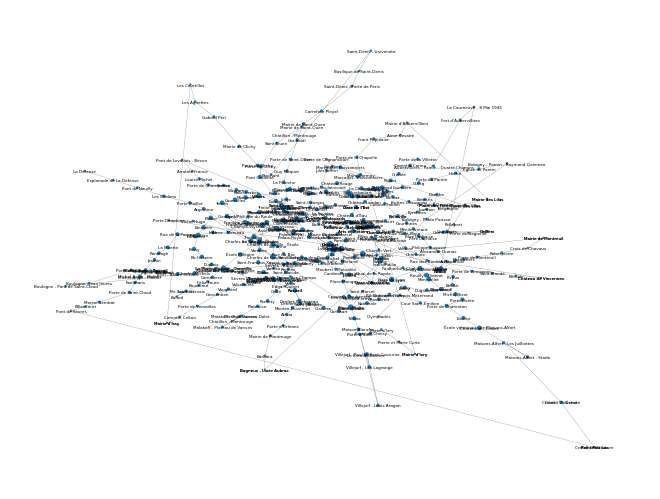

In [95]:
node_size = [node['traffic'] for node in network_graph.nodes.values()]
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in network_graph.nodes.items()}

nx.draw(network_graph, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(network_graph, 'title'), font_size=3)